In [3]:
"""
TODO:
- Get at least a reasonable looking change. Maybe start with bad initial conditions.
- Gg should be symmetric
- BFGS cannot handle constraints nor bounds
Jimin's: 
[0 8 5, 8 0 2, 5 2 0]
[0 2 8, 7 0 3, 7 7 0]
- Exciting excitatory
"""
import numpy as np
import project_path
from model.neural_model import NeuralModel

N = 3

is_inhibitory = np.array([1, 0 ,0])
dt = 0.01
simul_ts = 1500
eval_ts = 1000

# Only the second neuron is receiving constant input
I_ext = 100000 * np.array([0, 0.03 ,0])
#I_ext = np.array([30000.0] + [0] * (N-1))


def gen_random_connectome(N):
  """
  Return Gg (NxN), Gs (NxN)
  """
  
  # TODO: Revert this to random
  # Gg = np.random.rand(N,N)
  # Gs = np.random.rand(N,N)
  Gg = np.array([[0, 8, 5],
                 [8, 0, 2],
                 [5, 2, 0]])
  Gs = np.array([[0, 2, 8],
                 [7, 0, 3],
                 [7, 7, 0]])
  return (Gg, Gs)

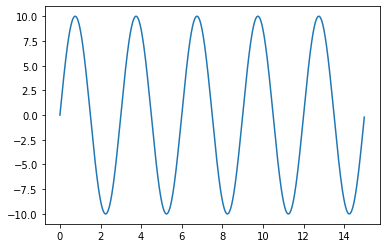

In [21]:
import pylab as plt

def get_gold_dynamics(simul_ts, dt):
  """
  Generate the golden dynamics for simul_ts
  The return value is already discretized according to dt 
  """
  # Period length in s
  simul_s = simul_ts*dt
  ts = np.arange(0, simul_s, dt)
  return ts, 10*np.sin((5 * 2 * np.pi/ simul_s) * ts)

ts, ys = get_gold_dynamics(simul_ts, dt)
plt.plot(ts, ys)

In [22]:
def ts_distance_euclidean(ts1, ts2):
  return np.linalg.norm(ts1 - ts2)
ts_distance_euclidean(np.array([1] * 5), np.array([0] * 5))

2.23606797749979

In [23]:
from sklearn.decomposition import PCA
import pdb

def unpack_param_vec(x):
  gg_vec = x[:N*N]
  gs_vec = x[N*N:2*N*N]
  gg_mat = gg_vec.reshape(N,N)
  gs_mat = gs_vec.reshape(N,N)
  return gg_mat, gs_mat

def run_neural_model(N, Gg, Gs, simul_ts):
  model = NeuralModel(
    N = N,
    Gg = Gg,
    Gs = Gs,
    is_inhibitory = is_inhibitory,
    I_ext = I_ext)
  
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_ts)

  # Reduce dimension of model dynamics
  pca = PCA(n_components = 1)
  projected_X = pca.fit_transform(v_normalized_mat)

  # Return just the first PCA comp, and just the last bits
  return projected_X[:,0]

def create_obj_fun(N, gold_dynamics, eval_ts):
  def obj_fun(x):
    simul_ts = 3000
    gg_mat, gs_mat = unpack_param_vec(x)
    actual_dyn = run_neural_model(N, gg_mat, gs_mat, simul_ts)
    error = ts_distance_euclidean(gold_dynamics[-eval_ts:], actual_dyn[-eval_ts:])
    return error
  return obj_fun

Total runtime = 0.13s
Error before optimization = 379.27947400250383


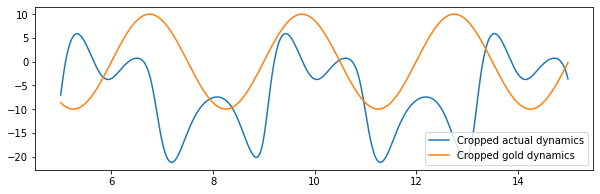

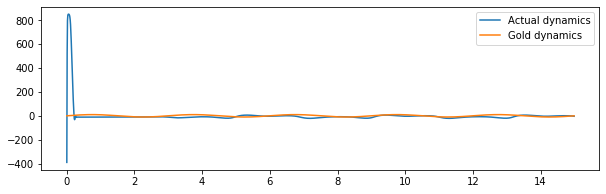

In [24]:
# Initial run
Gg, Gs = gen_random_connectome(N)
ts, gold_dyn = get_gold_dynamics(simul_ts, dt)

actual_dyn = run_neural_model(N, Gg, Gs, simul_ts)
cropped_actual_dyn = actual_dyn[-eval_ts:]
cropped_gold_dyn = gold_dyn[-eval_ts:]
error = ts_distance_euclidean(cropped_gold_dyn, cropped_actual_dyn)
cropped_ts = ts[-eval_ts:]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(cropped_ts, cropped_actual_dyn, label = "Cropped actual dynamics")
ax.plot(cropped_ts, cropped_gold_dyn, label = "Cropped gold dynamics")
ax.legend()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(ts, actual_dyn, label = "Actual dynamics")
ax.plot(ts, gold_dyn, label = "Gold dynamics")
ax.legend()


print("Error before optimization = " + str(error))

In [20]:
# Optimize
from scipy.optimize import minimize

obj_fun = create_obj_fun(N, gold_dynamics)
bnds = [(0, None)] * (2 * N**2)
init_cond_arr = np.concatenate([Gg.flatten(), Gs.flatten()])

res = minimize(obj_fun, init_cond_arr, method='BFGS', bounds=bnds)
print(res)

NameError: name 'gold_dynamics' is not defined

In [ ]:
# Plot the optimized results
new_Gg, new_Gs = unpack_param_vec(res.x)

normalized_run_dyn = run_neural_model(N, new_Gg, new_Gs, gold_dynamics)
error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(ts, normalized_run_dyn, label = "Actual dynamics")
ax.plot(ts, gold_dynamics, label = "Gold dynamics")
ax.legend()
print("Error after optimization = " + str(error))